# Import

In [1]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from fvcore.nn import FlopCountAnalysis, flop_count_table
import numpy as np
import matplotlib.pyplot as plt
import os
####################################################
from src.Mydataloader import LoadDataset
from src.Mymodel import Block
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR
from src.Mytraining import DoTraining

# Setup

In [2]:
"""Dataset selection"""
DATASET = "CIFAR10"
# DATASET = "CIFAR100"
# DATASET = "ImageNet2012"

"""Model selection for CIFAR"""
NUM_LAYERS_LEVEL = 5

"""Dataset parameters"""
BATCH = 256
SHUFFLE = True
NUMOFWORKERS = 8
PIN_MEMORY = True
SPLIT_RATIO = 0
"""optimizer parameters"""
OPTIMIZER = "SGD"
# OPTIMIZER = "Adam"
# OPTIMIZER = "Adam_decay"

"""Learning rate scheduler parameters"""
LOAD_BEFORE_TRAINING = False
LOAD_BEFORE_TRAINING = True
NUM_EPOCHS = 50000

"""Early stopping parameters"""
EARLYSTOPPINGPATIENCE = 1200
file_path = ""
if DATASET == "ImageNet2012":
    file_path = f"{DATASET}/MyResNet34_{BATCH}_{OPTIMIZER}"
else:
    file_path = f"{DATASET}/MyResNet{NUM_LAYERS_LEVEL*6+2}_{BATCH}_{OPTIMIZER}"
    
if SPLIT_RATIO != 0:
    file_path += f"_{int(SPLIT_RATIO*100)}"

In [3]:
file_path

'CIFAR10/MyResNet32_256_SGD'

# Loading the dataset

## Define Dateloader

In [4]:
from src.Mydataloader import LoadDataset

In [5]:
tmp = LoadDataset(root="data", seceted_dataset=DATASET, split_ratio=SPLIT_RATIO)
train_data, valid_data, test_data, COUNT_OF_CLASSES = tmp.Unpack()

/home/lee/anaconda3/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


-----------------------------------------------------------------------
Dataset :  CIFAR10
- Length of Train Set :  50000
- Length of Test Set :  10000
- Count of Classes :  10
-----------------------------------------------------------------------


In [6]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("train.transforms =", train_data.transform, train_dataloader.batch_size)

if SPLIT_RATIO != 0:
    valid_dataloader = DataLoader(
        valid_data,
        batch_size=BATCH,
        shuffle=SHUFFLE,
        num_workers=NUMOFWORKERS,
        pin_memory=PIN_MEMORY,
        # pin_memory_device="cuda",
        persistent_workers=True,
    )
    print("valid.transforms =", valid_data.transform, valid_dataloader.batch_size)
elif SPLIT_RATIO == 0:
    valid_dataloader = None

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH,
    shuffle=SHUFFLE,
    num_workers=NUMOFWORKERS,
    pin_memory=PIN_MEMORY,
    # pin_memory_device="cuda",
    persistent_workers=True,
)
print("test.transforms =", test_data.transform, test_dataloader.batch_size)

train.transforms = Compose(
      ToTensor()
      Submean()
      RandomHorizontalFlip(p=0.5)
) 256
test.transforms = Compose(
      ToTensor()
      Submean()
) 256


## Confirm that the dataset is loaded properly

In [7]:
if DATASET != "ImageNet2012":
    for X, y in test_dataloader:
        print(f"Shape of X [N, C, H, W]: {X.shape}")
        print("mean of X", X.mean(dim=(0, 2, 3)))
        print(f"Shape of y: {y.shape} {y.dtype}")
        break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
mean of X tensor([-3.2476e-09, -4.1418e-09, -4.5446e-09])
Shape of y: torch.Size([256]) torch.int64


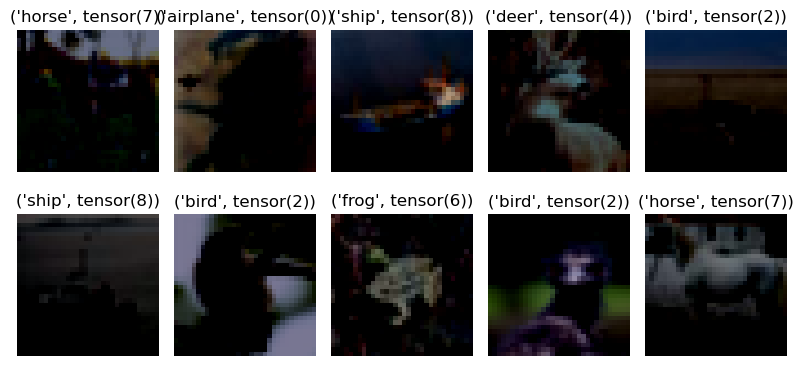

In [8]:
if DATASET != "ImageNet2012":
    class_names = test_dataloader.dataset.classes
    count = 0
    fig, axs = plt.subplots(2, 5, figsize=(8, 4))

    for images, labels in test_dataloader:
        images = images.numpy()

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            image = np.transpose(image, (1, 2, 0))
            image = np.clip(image, 0, 1)
            ax = axs[count // 5, count % 5]
            ax.imshow(image)
            ax.set_title(f"{class_names[label], label}")
            ax.axis('off')
            count += 1
            
            if count == 10:
                break
        if count == 10:
            break
    plt.tight_layout()
    plt.show()

# Define ResNet

In [9]:
from src.Mymodel import MyResNet34
from src.Mymodel import MyResNet_CIFAR

## Model Confirm

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [11]:
if DATASET == "CIFAR10" or DATASET == "CIFAR100":
    """ResNet{20, 32, 44, 56, 110, 1202} for CIFAR"""
    model = MyResNet_CIFAR(
        num_classes=COUNT_OF_CLASSES, num_layer_factor=NUM_LAYERS_LEVEL
    ).to(device)
    print(f"ResNet-{5*6+2} for {DATASET} is loaded.")

elif DATASET == "ImageNet2012":
    """ResNet34 for ImageNet 2012"""
    model = MyResNet34(num_classes=COUNT_OF_CLASSES).to(device)
    # model = models.resnet34(pretrained=True).to(device)
    # model = models.resnet34(pretrained=False).to(device)
    print(f"ResNet-34 for {DATASET} is loaded.")

# model.named_modules

ResNet-32 for CIFAR10 is loaded.


In [12]:
tmp_input = torch.rand(BATCH, 3, 32, 32).to(device)
flops = FlopCountAnalysis(model, tmp_input)
print(flop_count_table(flops))

| module                   | #parameters or shape   | #flops     |
|:-------------------------|:-----------------------|:-----------|
| model                    | 0.464M                 | 17.997G    |
|  conv32blocks            |  23.792K               |  6.363G    |
|   conv32blocks.0         |   0.432K               |   0.113G   |
|    conv32blocks.0.weight |    (16, 3, 3, 3)       |            |
|   conv32blocks.1         |   4.672K               |   1.25G    |
|    conv32blocks.1.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn1    |    32                  |    20.972M |
|    conv32blocks.1.conv2  |    2.304K              |    0.604G  |
|    conv32blocks.1.bn2    |    32                  |    20.972M |
|   conv32blocks.2         |   4.672K               |   1.25G    |
|    conv32blocks.2.conv1  |    2.304K              |    0.604G  |
|    conv32blocks.2.bn1    |    32                  |    20.972M |
|    conv32blocks.2.conv2  |    2.304K              |    0.604

# Define Training

## Define Optimazer
#### ResNet32 for CIFAR10
- SGD
- Batch size = 128 * 2 GPU
- lr : 0.1 -> 0.01 -> 0.001 (at 32k, 48k and terminate on 64k iter)
  - divided by 10 when the error plateaus
- Weight Decay = 0.0001
- Momentum = 0.9
#### ResNet34 for ImageNet2012
- SGD
- Batch size = 256
- lr = 0.1
  - divided by 10 when the error plateaus
  - amount 60k iter
- Weight Decay = 0.0001
- Momentum = 0.9

In [13]:
criterion = nn.CrossEntropyLoss()

if OPTIMIZER == "Adam":
    optimizer = torch.optim.Adam(model.parameters())
    # optimizer = torch.optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-4)
elif OPTIMIZER == "Adam_decay":
    optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001
    )

## Define Early Stopping

In [14]:
# Early stopping 관련 변수 초기화
best_val_loss = float("inf")
early_stop_counter = 0

## Define Learning Rate schedualer

In [15]:
scheduler_mapping = {"CIFAR100": 100, "CIFAR10": 1000, "ImageNet2012": 30}
MIN_LR = 0.0001
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    patience=scheduler_mapping[DATASET],
    factor=0.1,
    verbose=True,
    threshold=1e-4,
    min_lr=MIN_LR,
)

In [16]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

## Load before process

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=True)

if LOAD_BEFORE_TRAINING == True and os.path.exists("logs/" + file_path + ".pth.tar"):
        # Read checkpoint as desired, e.g.,
        checkpoint = torch.load(
            "logs/" + file_path + ".pth.tar",
            map_location=lambda storage, loc: storage.cuda(device),
        )
        model.load_state_dict(checkpoint["model"])
        optimizer.load_state_dict(checkpoint["optimizer"])
        scaler.load_state_dict(checkpoint["scaler"])
        logs = checkpoint["logs"]

        print("Suceessfully loaded the All setting and Log file.")
        print(file_path)
        print(f"Current epoch is {len(logs['train_loss'])}")
        print(f"Current learning rate: {optimizer.param_groups[0]['lr']}")        
else:
    # Create a dictionary to store the variables
    train_loss = []
    train_acc = []
    eval_loss = []
    valid_acc = []
    test_loss = []
    test_acc = []

    logs = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "valid_loss": eval_loss,
        "valid_acc": valid_acc,
        "test_loss": test_loss,
        "test_acc": test_acc,
    }
    print("File does not exist. Created a new log.")
    

Suceessfully loaded the All setting and Log file.
CIFAR10/MyResNet32_256_SGD
Current epoch is 5243
Current learning rate: 0.01


In [18]:
# CHECK = 5410
# logs["train_loss"] = logs["train_loss"][:CHECK]
# logs["train_acc"] = logs["train_acc"][:CHECK]
# logs["valid_loss"] = logs["valid_loss"][:CHECK]
# logs["valid_acc"] = logs["valid_acc"][:CHECK]
# logs["test_loss"] = logs["test_loss"][:CHECK]
# logs["test_acc"] = logs["test_acc"][:CHECK]
# model.load_state_dict(torch.load(f"models/{file_path}.pth"))

# [Training Loop]

In [19]:
from src.Mytraining import DoTraining

In [20]:
Training = DoTraining(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    scheduler=scheduler,
    device=device,
    logs=logs,
    file_path=file_path,
)
pre_epochs = len(Training.logs["train_loss"])

for epoch in range(NUM_EPOCHS):
    now = epoch + 1 + pre_epochs
    print(f"[Epoch {epoch+1+pre_epochs}/{NUM_EPOCHS}] :")

    if DATASET == "ImageNet2012":
        eval_loss = Training.SingleEpoch(train_dataloader, valid_dataloader)
    else:
        eval_loss = Training.SingleEpoch(
            train_dataloader, valid_dataloader, test_dataloader
        )

    # Early stopping check
    if eval_loss < best_val_loss:
        best_val_loss = eval_loss
        early_stop_counter = 0
        print(best_val_loss)
        torch.save(model.state_dict(), "models/" + file_path + ".pth")

    else:
        early_stop_counter += 1
        if early_stop_counter >= EARLYSTOPPINGPATIENCE:
            print(f"Early stopping after {epoch} epochs without improvement.")
            break

    print("-" * 50)

[Epoch 5244/50000] :


100%|██████████| 196/196 [00:07<00:00, 25.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3160 | Test Acc: 91.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
0.3159662462770939
--------------------------------------------------
[Epoch 5245/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.82it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3115 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
0.31149833560630213
--------------------------------------------------
[Epoch 5246/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3144 | Test Acc: 91.45%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5247/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.23it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3187 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5248/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.88it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3102 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
0.31015235036611555
--------------------------------------------------
[Epoch 5249/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.79it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3317 | Test Acc: 91.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5250/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3185 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5251/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.91it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3259 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5252/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.40it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3111 | Test Acc: 91.28%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5253/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.63it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3130 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5254/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3130 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5255/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.55it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3243 | Test Acc: 91.44%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5256/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3157 | Test Acc: 91.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5257/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.36it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3098 | Test Acc: 91.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
0.30980746656423436
--------------------------------------------------
[Epoch 5258/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.53it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3248 | Test Acc: 91.47%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5259/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.24it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3158 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5260/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.83it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3290 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5261/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.72it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3113 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5262/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.96it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3189 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5263/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3131 | Test Acc: 91.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5264/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3198 | Test Acc: 91.48%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5265/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.17it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3191 | Test Acc: 91.44%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5266/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.57it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3465 | Test Acc: 91.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5267/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3205 | Test Acc: 91.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5268/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.94it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3247 | Test Acc: 91.42%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5269/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.12it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3127 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5270/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.24it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3191 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5271/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3101 | Test Acc: 91.44%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5272/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.66it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3347 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5273/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.12it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3380 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5274/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.63it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3185 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5275/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.31it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3272 | Test Acc: 91.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5276/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.42it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3143 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5277/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.88it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3151 | Test Acc: 91.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5278/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3133 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5279/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.86it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3151 | Test Acc: 91.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5280/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.94it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3348 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5281/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3258 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5282/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.93it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3212 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5283/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.91it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3292 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5284/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.67it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3113 | Test Acc: 91.52%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5285/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.41it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3150 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5286/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.37it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3289 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5287/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.25it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3169 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5288/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.59it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3191 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5289/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.14it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3260 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5290/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.86it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3121 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5291/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.73it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3113 | Test Acc: 91.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5292/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.57it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3269 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5293/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.77it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3116 | Test Acc: 91.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5294/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3141 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5295/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.77it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3123 | Test Acc: 91.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5296/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.63it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3412 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5297/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.99it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3127 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5298/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.83it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3137 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5299/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.93it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3301 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5300/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.17it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3202 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5301/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.70it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3119 | Test Acc: 91.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5302/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.70it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3166 | Test Acc: 91.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5303/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.47it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3256 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5304/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.69it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3144 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5305/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3138 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5306/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3294 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5307/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3187 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5308/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.12it/s]


Train Loss: 0.0001 | Train Acc: 100.00%
Test  Loss: 0.3260 | Test Acc: 91.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5309/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.11it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3162 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5310/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.44it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3229 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5311/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.41it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3183 | Test Acc: 91.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5312/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.49it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3294 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5313/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.36it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3230 | Test Acc: 91.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5314/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.29it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3148 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5315/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.16it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3166 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5316/50000] :


100%|██████████| 196/196 [00:07<00:00, 27.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3262 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5317/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3114 | Test Acc: 91.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5318/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.73it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3188 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5319/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.80it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3174 | Test Acc: 91.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5320/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3257 | Test Acc: 91.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5321/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3166 | Test Acc: 91.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5322/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3253 | Test Acc: 91.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5323/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.73it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3155 | Test Acc: 91.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5324/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.25it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3214 | Test Acc: 91.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5325/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.60it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3131 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5326/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.74it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3140 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5327/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3139 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5328/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.44it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3259 | Test Acc: 91.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5329/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.59it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3183 | Test Acc: 91.17%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5330/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.00it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3132 | Test Acc: 91.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5331/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.67it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3174 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5332/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3132 | Test Acc: 91.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5333/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.68it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3165 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5334/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.80it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3141 | Test Acc: 91.42%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5335/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.67it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3161 | Test Acc: 91.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5336/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.75it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3172 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5337/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.55it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3225 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5338/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.82it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3116 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5339/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.04it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3204 | Test Acc: 91.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5340/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.72it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3188 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5341/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.78it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3212 | Test Acc: 91.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5342/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.41it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3345 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5343/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3188 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5344/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3228 | Test Acc: 91.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5345/50000] :


100%|██████████| 196/196 [00:07<00:00, 28.00it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3132 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5346/50000] :


100%|██████████| 196/196 [00:07<00:00, 27.93it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3136 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5347/50000] :


100%|██████████| 196/196 [00:07<00:00, 27.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3125 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5348/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3372 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5349/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.37it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3246 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5350/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.55it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3180 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5351/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.40it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3157 | Test Acc: 91.46%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5352/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.10it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3189 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5353/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3137 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5354/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.91it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3149 | Test Acc: 91.43%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5355/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.81it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3228 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5356/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.72it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3157 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5357/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.30it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3274 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5358/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.75it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3265 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5359/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.45it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3126 | Test Acc: 91.45%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5360/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.74it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3275 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5361/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.46it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3226 | Test Acc: 91.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5362/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.43it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3165 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5363/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3165 | Test Acc: 91.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5364/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3133 | Test Acc: 91.45%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5365/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3264 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5366/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.16it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3194 | Test Acc: 91.42%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5367/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.91it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3212 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5368/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.67it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3147 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5369/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.82it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3215 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5370/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.49it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3255 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5371/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.58it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3259 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5372/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.46it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3183 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5373/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.41it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3367 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5374/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.76it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3174 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5375/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3142 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5376/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.34it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3178 | Test Acc: 91.28%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5377/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.33it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3284 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5378/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.37it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3219 | Test Acc: 91.20%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5379/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.18it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3257 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5380/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.52it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3184 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5381/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3233 | Test Acc: 91.41%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5382/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.62it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3173 | Test Acc: 91.42%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5383/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3224 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5384/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.19it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3209 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5385/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3265 | Test Acc: 91.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5386/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.46it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3300 | Test Acc: 91.28%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5387/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.87it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3229 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5388/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3213 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5389/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.11it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3258 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5390/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.60it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3221 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5391/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.66it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3222 | Test Acc: 91.47%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5392/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.59it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3277 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5393/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.87it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3232 | Test Acc: 91.42%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5394/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.66it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3212 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5395/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.61it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3222 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5396/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3301 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5397/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.55it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3333 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5398/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.89it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3307 | Test Acc: 91.40%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5399/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3182 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5400/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.90it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3171 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5401/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.94it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3209 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5402/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.46it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3213 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5403/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.28it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3195 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5404/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.34it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3292 | Test Acc: 91.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5405/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.05it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3388 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5406/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.18it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3217 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5407/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3295 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5408/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.75it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3346 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5409/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3194 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5410/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.86it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3192 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5411/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.56it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3357 | Test Acc: 91.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5412/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.74it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3250 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5413/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.58it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3321 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5414/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.36it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3228 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5415/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.37it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3297 | Test Acc: 91.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5416/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.92it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3189 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5417/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.44it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3254 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5418/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.05it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3190 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5419/50000] :


100%|██████████| 196/196 [00:07<00:00, 27.93it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3345 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5420/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.76it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3412 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5421/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.53it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3230 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5422/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.82it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3189 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5423/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3207 | Test Acc: 91.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5424/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.03it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3204 | Test Acc: 91.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5425/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.25it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3255 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5426/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.77it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3201 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5427/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.77it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3207 | Test Acc: 91.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5428/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3196 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5429/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.80it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3276 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5430/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.72it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3413 | Test Acc: 91.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5431/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.40it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3279 | Test Acc: 91.28%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5432/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.06it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3205 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5433/50000] :


100%|██████████| 196/196 [00:07<00:00, 27.96it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3369 | Test Acc: 91.34%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5434/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.14it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3332 | Test Acc: 91.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5435/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.27it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3251 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5436/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.41it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3202 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5437/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.60it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3235 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5438/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.60it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3345 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5439/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.69it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3273 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5440/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.32it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3281 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5441/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.57it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3403 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5442/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.51it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3359 | Test Acc: 91.39%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5443/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.89it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3299 | Test Acc: 91.28%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5444/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.75it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3213 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5445/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.94it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3514 | Test Acc: 91.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5446/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.72it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3242 | Test Acc: 91.25%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5447/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3226 | Test Acc: 91.21%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5448/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.88it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3247 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5449/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.10it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3206 | Test Acc: 91.26%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5450/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.55it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3332 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5451/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.39it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3233 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5452/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.77it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3278 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5453/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.35it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3243 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5454/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.57it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3343 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5455/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.60it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3251 | Test Acc: 91.22%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5456/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.58it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3345 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5457/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.09it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3293 | Test Acc: 91.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5458/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.88it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3279 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5459/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.72it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3257 | Test Acc: 91.37%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5460/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.58it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3291 | Test Acc: 91.29%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5461/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.53it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3217 | Test Acc: 91.35%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5462/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.30it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3243 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5463/50000] :


100%|██████████| 196/196 [00:07<00:00, 27.95it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3250 | Test Acc: 91.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5464/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3298 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5465/50000] :


100%|██████████| 196/196 [00:07<00:00, 27.98it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3320 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5466/50000] :


100%|██████████| 196/196 [00:07<00:00, 27.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3264 | Test Acc: 91.32%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5467/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.02it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3375 | Test Acc: 91.23%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5468/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.64it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3319 | Test Acc: 91.19%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5469/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.51it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3251 | Test Acc: 91.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5470/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.35it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3415 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5471/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.40it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3298 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5472/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.85it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3266 | Test Acc: 91.30%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5473/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.07it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3401 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5474/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3280 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5475/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.97it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3320 | Test Acc: 91.28%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5476/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.59it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3321 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5477/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.96it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3276 | Test Acc: 91.36%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5478/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.13it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3346 | Test Acc: 91.24%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5479/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.79it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3293 | Test Acc: 91.27%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5480/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.65it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3399 | Test Acc: 91.38%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5481/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.66it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3399 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5482/50000] :


100%|██████████| 196/196 [00:06<00:00, 29.12it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3350 | Test Acc: 91.33%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5483/50000] :


100%|██████████| 196/196 [00:06<00:00, 28.38it/s]


Train Loss: 0.0000 | Train Acc: 100.00%
Test  Loss: 0.3296 | Test Acc: 91.31%
Saved PyTorch Model State to [logs/CIFAR10/MyResNet32_256_SGD.pth.tar]
--------------------------------------------------
[Epoch 5484/50000] :


 73%|███████▎  | 143/196 [00:05<00:01, 30.09it/s]

In [ ]:
file_path

## Training Results

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

# 첫 번째 그래프: Training and Test Loss
axs[0].plot(logs["train_loss"], label="Training Loss")
axs[0].plot(logs["valid_loss"], label="Validation Loss")
axs[0].plot(logs["test_loss"], label="Test Loss")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training, Validation and Test Loss")
axs[0].legend()

# 두 번째 그래프: Training and Test Accuracy
axs[1].plot(logs["train_acc"], label="Training Accuracy")
axs[1].plot(logs["valid_acc"], label="Validation Accuracy")
axs[1].plot(logs["test_acc"], label="Test Accuracy")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Accuracy")
axs[1].set_title("Training, Validation and Test Accuracy")
axs[1].legend()

# 그래프를 보여줍니다.
plt.tight_layout()
plt.show()

In [ ]:
print(len(logs["train_loss"]))
print(len(logs["train_acc"]))
print(len(logs["valid_loss"]))
print(len(logs["valid_acc"]))
print(len(logs["test_loss"]))
print(len(logs["test_acc"]))

- 주피터노트북 output set
- @tag:notebookOutputLayout

In [ ]:
for i in range(len(logs["train_loss"])):
    print(
        f"{i+1} epoch: train_loss={logs['train_loss'][i]:.4f}, train_acc={logs['train_acc'][i]:.4f}, test_loss={logs['test_loss'][i]:.4f}, test_acc={logs['test_acc'][i]:.4f}"
    )